# LangSmith Tutorial: Building an Advanced Flashcards Generator From Text Input Wit LangSmith

## Table of contents

1. Why LangSmith?
2. LangSmith vs. LangChain
3. Setting up LangSmith
4. LangSmith platform overview
5. Getting started with LangSmith Python SDK
   1. Setting up tracing
   2. Creating a LangSmith client and running an initial prompt
   3. Creating an unlabeled dataset in LangSmith
6. Evaluating LLMs in LangSmith
   1. Basic evaluation types for unlabeled datasets
   2. Creating labeled datasets from various sources
   3. Writing custom evaluations
7. Conclusion

## Introduction

I recently found an AI platform that automatically generates flashcards from any type of media. Since I love memorizing things with spaced repetition, I immediately uploaded my XGBoost tutorial and asked the AI to create 50 flashcards on it. 

But... I was disappointed. Most of the questions were too easy and very few of them were about code syntax. Even more strangely, 10% of the questions were identical - "What is the capital of France?" (Yep, right in the middle of an XGBoost tutorial). 

These types of embarrassing mistakes aren't the fault of the LLM behind the platform or not even the fault of the developers (well, partly) because we didn't have a reliable way of evaluating LLM outputs in production. Until just recently...

LangSmith is a full-fledged platform to test, debug and evaluate LLM applications. Perhaps, its most important feature is LLM output evaluation and performance monitoring. In this tutorial, we will see both the LangSmith platform and its Python framework in action by building our own basic flashcards generator. 

Let's get started!

## Why LangSmith?

As I mentioned above, LangSmith is a comprehensive platform to evaluate large language applications. Here are some of its features and tangible real-world benefits they bring:

1. Quick setup

Programmers can start experimenting with LangSmith in minutes, not hours. This means a small team or a solo developer can prototype an AI application over a weekend and potentially ship a paid service by Monday.

2. Quality assurance

With rigorous evaluation tools, companies can avoid the embarrassment and cost of faulty AI releases (like the example I gave in the beginning). LangSmith allows you to check the output of LLMs against built-in criteria such as helpfulness, coherence, misogyny or even custom evaluations in natural language like "Is the content of the output cliche?", or in our case "Does the card contain a coding question?". 

3. Real-time monitoring and visualization

LangSmith uses traces to log almost everything aspect of LLM runs. These include metrics such as latency, token count, run price (based on the model provider), and all types of metadata. The Web UI allows you quickly pinpoint runs based on error percentage, latency, date, or even by content using natural languages. These means that if, for instance, an AI  tutor starts hallucinating to actual students, you can push out a fix in a few hours. 

4. Integration with LangChain

LangChain is the parent framework of LangSmith focused specifically on the development phase of LLMs. It offers modular software design to chain multiple LLMs (agents) and integrate them with other APIs such as YouTube, Google Search and so on. LangSmith is the cherry on top, ensuring that prototypes built with LangChain perform as expected by using its powerful evaluation and monitoring tools. Check out this article to learn more about LangChain.

5. Datasets

Another great feature of LangSmith is datasets. They can be used to improve LangChain chains, agents or models against a set of standardized examples before deployment. For example, we may have a CSV file containing two columns -  questions, answers for flashcards in a specific format. By uploading this file as a dataset and using it as an evaluator, we can enforce all flashcards generated into a specific format or context. 

We will now see all these features through examples one-by-one.

## LLM application development workflow

In ML app development, you collect data, train, fine-tune, test, and deploy. With LLM apps, though, you often start with a ready-made model from a vendor. Fine-tuning? That can be expensive. So, you'll focus a lot on crafting the right prompts - it's all about asking your LLM app the right questions. Think of it as needing lots of prompts to test things out, just like you need lots of data for a good ML model.
However, w With prompts, you're dealing with texts coming in and out, not numbers. So, the usual ways to measure errors or accuracy, like MSE or Cross-entropy, don't work here. Plus, imaginreading every input and output for evaluationnd - not happening.

So, youneedwith a workflow that's all about efficiently creating and testing these prompts to see how well your LLM app is doing, without drowning in manual ch. Here is what that might look like:cks.

1. Develop

In this stage, you will prototype the bedrock of your application using frameworks like LangChain. For flashcards generator project, your prototype might include multiple components on top of your chosen LLM from a vendor. For example, you may need to chain it to:
- Retrievers: Search engine APIs, web scrapers
- Document loaders: File inputs - PDF, text, CSV, JSON, clipboard, YouTube, Search, etc.
- Chat loaders
- Vector stores
- Embedding models
- Callbacks

and so on (see what kind of components you can add [here](https://python.langchain.com/docs/integrations/componentsBut you mayalso cut your development time drastically by using [off-the-shelf chains](https://python.langchain.com/docs/modules/chains) offered by LangChain for common high-level tasks.

For a sample workflow using LangChain, you can visit this [article](https://www.datacamp.com/tutorial/how-to-build-llm-applications-with-langchain).

2. Productionize

In this stage, you will test your application against as many scenarios as you can. This means you have to ensure every added component works well, they chain together well and produce consistent high-quality outputs. 

Given LLMs are non-deterministic (they don't generate the same output for the same input) and the complexity of added components, you will spend most of your time in this stage. And LangSmith was developed with the sole purpose of making that time as short as possible. More on this throughout the tutorial.

3. Deploy

Once you have a viable application, you can deploy it as a REST API. A REST API basically converts your existing LangChain chains or agents into HTTPS links others can send requests to interact with YI, you will build the user interface of your service like a desktop application or more commonly, a website. 

Right now, there is no easy way to do this but LangChain developers are about to release LangServe which will be integrated into FastAPI (how awesome would that be?). Check out the sneak peak from [this page](https://python.langchain.com/docs/langserve) of the documentat

Now, let's finally start tinkering with LangSmith.ion.

## LangSmith platform overview

We will begin with understanding the web UI. It is available through [smith.langchain.com](smith.langchain.com) link. For access, you have to sign up and get cleared from the waitlist as it is currently in closed beta. 

But once you are in, the landing page will look like this:

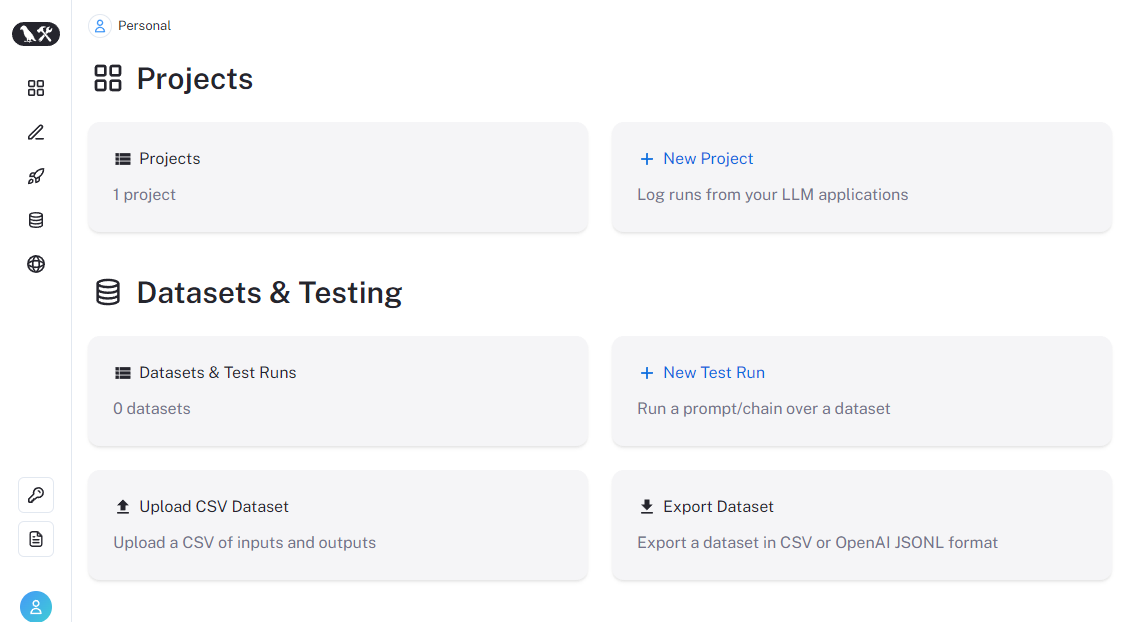

The two main sections are projects and datasets & testing and both sections can be manipulated through Python SDK. The platform also have tabs for deployment and annotation queues but they are beyond the scope of this article.

## Setting up LangSmith Python SDK

Managing projects in LangSmith is far easier with its Python SDK, which is connected to the platform through an API key. 

To get a key, click on the key icon in the platform and save it somewhere safe. Then, in a new directory with a new virtual environment initialized, create a .env file. Inside, paste the following two lines:

```toml
LANGCHAIN_API_KEY="LangSmith-API-key"
OPENAI_API_KEY="Your-OPENAI-key"
```

Next, in your terminal, run the following commands to install LangSmith and `python-dotenv` to read environment variables:

```
pip install -U langsmith
pip install python-dotenv
```

Now, time to write code:

In [4]:
import warnings

from dotenv import find_dotenv, load_dotenv

warnings.filterwarnings("ignore")

We import `find_dotenv` and `load_dotenv` functions to read environment variables and set them up with `os`:

In [25]:
import os

load_dotenv(find_dotenv())
os.environ["LANGCHAIN_API_KEY"] = str(os.getenv("LANGCHAIN_API_KEY"))
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"

Setting `LANGCHAIN_TRACING_V2` to True enables tracing (logging), which is essential to debugging LLMs. Afterwards, we initialize a client to talk to the LangSmith platform:

In [5]:
from langsmith import Client

# Initialize a client
client = Client()

`client` contains high-level commands to manipulate projects and assets in LangSmith. The first command of the client we will use is creating a new project:

In [22]:
import uuid

# Create id
uid = uuid.uuid4()
# Create a unique name
PROJECT_NAME = "flashcards-generator-" + str(uid)

In [23]:
# Create the project
session = client.create_project(
    project_name=PROJECT_NAME,
    description="A project that generates flashcards from user input",
)

After `create_project` successfully runs, you can see the project listed in the Projects section of the web UI:

![](images/create_project.gif)

Next, we need to set the new project as default with another environment variable:

In [26]:
os.environ["LANGCHAIN_PROJECT"] = PROJECT_NAME

Now, we need an LLM for our project. We will go with gpt-3.5 turbo since it is cheaper but you can use many other models available through `langchain`. OpenAI models are initialized through the `ChatOpenAI` class.

In [48]:
from langchain.chat_models import ChatOpenAI

llm = ChatOpenAI()  # Uses gpt-3.5-turbo by default


Let's do our first run:

In [49]:
llm.invoke("Hello, chatty, how you doin' today?")

AIMessage(content="Hello! I'm an AI language model, so I don't have feelings, but I'm here to help you. How can I assist you today?")

If you quickly check the project from the UI, you will see the run traced (logged):

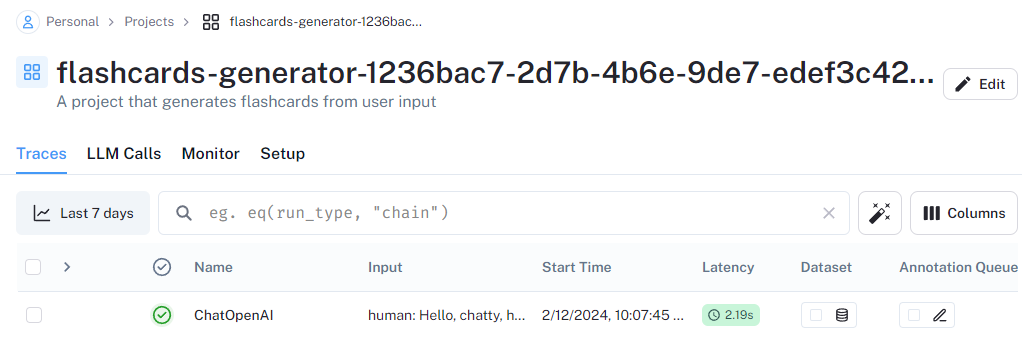

When we set up the environment variables and the client, we automatically enabled logging. As you can see, we already have a bunch of metadata about the run. 

![](images/first_run.gif)

Let's run a couple more prompts:

In [28]:
message = llm.invoke("Do you know how to generate flashcards?")

message.content[:50]

'Yes, I can help you generate flashcards. There are'

We can already build a basic text summarizer. Let's summarize the output of the last run:

In [29]:
prompt = f"Summarize this text: {message.content}"

summary = llm.invoke(prompt)
summary.content

'The text explains different methods for creating flashcards. These methods include writing on small index cards, using online flashcard generators, utilizing flashcard apps on mobile devices, and using word processing software like Microsoft Word or Google Docs. It emphasizes the importance of consistency in format and organization for effective studying.'

Great, now let's create our first dataset.

## Creating an unlabeled dataset in LangSmith

Like I mentioned in the "LLM application development workflow" section, you will likely need to create or collect thousands of prompts to evaluate your LLM model, chain or agent. So, running those one-by-one like we did above isn't best practice.

For this reason, LangSmith offers datasets in three types:

- [Key-value (`kv`)](https://docs.smith.langchain.com/evaluation/datasets#key-value-datasets) - default: Defines inputs as arbitrary key-value pairs. They are useful when evaluating chains and agents that require multiple inputs or return multiple outputs.
- [LLM datasets (`llm`)](https://docs.smith.langchain.com/evaluation/datasets#llm-datasets): Inputs and outputs are defined in "completion style" by LLMs - string in, string out.
- [Chat datasets (`chat`)](https://docs.smith.langchain.com/evaluation/datasets#chat-datasets): These are datasets converted from LLM chats and defined using structured inputs and serialized messages. 

First, let's see how to create a key-value dataset with no outputs. We will use the `create_dataset` function of the `client`:

In [30]:
dataset_name = "deep_learning_fundamentals"

# Creating a blank dataset
dl_dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="A deck containing flashcards on NNs and PyTorch",
    data_type="kv",  # default
)

Now, let's add three inputs that each ask the LLM to create a single flashcard:

In [31]:
# Storing only inputs into a dataset
example_inputs = [
    "Generate a single flashcard on backpropogation",
    "Generate a single flashcard on the use of torch.no_grad",
    "Generate a single flashcard on how Adam optimizer",
]

for ex in example_inputs:
    # Each example input must be unique
    # The output is optional
    client.create_example(
        inputs={"input": ex},
        outputs=None,
        dataset_id=dl_dataset.id,
    )

If you go over the dataset tab of the UI, you will see each prompt listed with NULL output:

![](images/first_dataset.gif)

Now, let's run all the prompts in a single line of code using `run_on_dataset` function:

In [34]:
from langchain.smith import run_on_dataset

results = run_on_dataset(
    client=client,
    dataset_name=dataset_name,
    llm_or_chain_factory=llm,
    project_name="unlabeled_test",
)

View the evaluation results for project 'unlabeled_test' at:
https://smith.langchain.com/o/c50fc75b-a85e-5392-9845-1fd128ea9489/datasets/dc6af7fd-1ec9-4bd4-bdb6-00cde038a561/compare?selectedSessions=ea7e39fa-9dd2-40bd-9798-6a3aa9e49505

View all tests for Dataset deep_learning_fundamentals at:
https://smith.langchain.com/o/c50fc75b-a85e-5392-9845-1fd128ea9489/datasets/dc6af7fd-1ec9-4bd4-bdb6-00cde038a561
[------------------------------------------------->] 3/3

Once the run finishes, it will be listed in the dataset page. Here is how it looks like:

![](images/unlabeled_test.gif)

We just did a test run on an unlabeled dataset - a dataset with example prompts but no example outputs. Our test simply produced a response to each prompt but didn't evaluate anything. But we'd like to perform basic checks such as "Is the output helpful?" or "Is the response short or long"?

LangSmith allows us to perform such checks using built-in evaluators.

## Evaluating LLMs in LangSmith

To run a `conciseness` and `coherence` evaluations using the three prompts we have in our dataset, we can use the `RunEvalConfig` class:

In [35]:
from langchain.smith import RunEvalConfig

# List the eval criteria
eval_config = RunEvalConfig(
    evaluators=[
        RunEvalConfig.Criteria("conciseness"),
        RunEvalConfig.Criteria("coherence"),
    ]
)

Above, we are defining two criterion in a list called `evaluators`. We pass these evaluators to the `evaluation` parameter of `run_on_dataset` function:

In [36]:
results = run_on_dataset(
    client=client,
    dataset_name=dataset_name,
    llm_or_chain_factory=llm,
    evaluation=eval_config,
    project_name="criteria_test",
)

View the evaluation results for project 'criteria_test' at:
https://smith.langchain.com/o/c50fc75b-a85e-5392-9845-1fd128ea9489/datasets/dc6af7fd-1ec9-4bd4-bdb6-00cde038a561/compare?selectedSessions=b8f33386-b549-4206-a777-ad6e9356a2fe

View all tests for Dataset deep_learning_fundamentals at:
https://smith.langchain.com/o/c50fc75b-a85e-5392-9845-1fd128ea9489/datasets/dc6af7fd-1ec9-4bd4-bdb6-00cde038a561
[------------------------------------------------->] 3/3

`run_on_dataset` is a helpful function to run all prompts in a dataset using the provided LLM and perform any type of evaluations on the fly. Its results will be visible in the dedicated page of each dataset:

![](images/criteria_test.gif)

This time, the run has coherence and conciseness metrics for each prompt. At the bottom, you will also see an average score for each metric. 

To see the list of all built-in criterion, run the below snippet:

In [37]:
from langchain.evaluation import Criteria

list(Criteria)

[<Criteria.CONCISENESS: 'conciseness'>,
 <Criteria.RELEVANCE: 'relevance'>,
 <Criteria.CORRECTNESS: 'correctness'>,
 <Criteria.COHERENCE: 'coherence'>,
 <Criteria.HARMFULNESS: 'harmfulness'>,
 <Criteria.MALICIOUSNESS: 'maliciousness'>,
 <Criteria.HELPFULNESS: 'helpfulness'>,
 <Criteria.CONTROVERSIALITY: 'controversiality'>,
 <Criteria.MISOGYNY: 'misogyny'>,
 <Criteria.CRIMINALITY: 'criminality'>,
 <Criteria.INSENSITIVITY: 'insensitivity'>,
 <Criteria.DEPTH: 'depth'>,
 <Criteria.CREATIVITY: 'creativity'>,
 <Criteria.DETAIL: 'detail'>]

## Writing custom evaluators in LangSmith for unlabeled datasets

Of course, not all LLM use-cases can be covered with basic evaluators. For example, there is no evaluator to check whether a flashcard contains a coding question or not. So, we better define it:

In [38]:
eval_config = RunEvalConfig(
    evaluators=[
        RunEvalConfig.Criteria(
            {"has_code": "Does the card contain a code syntax question?"}
        ),
        RunEvalConfig.Criteria(
            {
                "is_vague": "Is the front of the flashcard vague, meaning it hasn't enough context to answer?"
            }
        ),
    ]
)

To pass a custom criteria with a natural language, we simply pass {"criteria_name": "Condition to check"} to `Criteria` class. Above, we are creating two extra evaluators, so LangSmith will run two additional prompts on top of the output produced by the prompts in our dataset:

In [ ]:
# Run the evaluation
results = run_on_dataset(
    client,
    dataset_name,
    llm,
    evaluation=eval_config,
    project_name="custom_criteria_test",
)

If you check out the run, you will see the custom criterion we've defined under each prompt. If you hover over, you will get the reasoning of the LLM after running the evaluation:

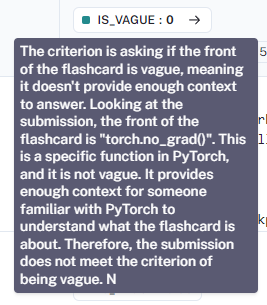

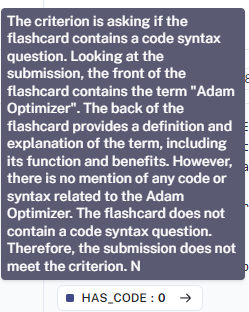

By checking the evaluation results for all prompts, you will see that our criterion aren't evaluating as expected. So, here is something to consider - you also need to prompt-engineer your criterion to ensure they check the right things. 

## Creating labeled datasets

Sometimes, you may decide to create a dataset of prompts with expected outputs, e.g. labeled datasets. You can create labeled datasets in various formats but perhaps the most common one is a CSV file. For example, here is a file I generated with ChatGPT that contains five questions on PyTorch syntax:

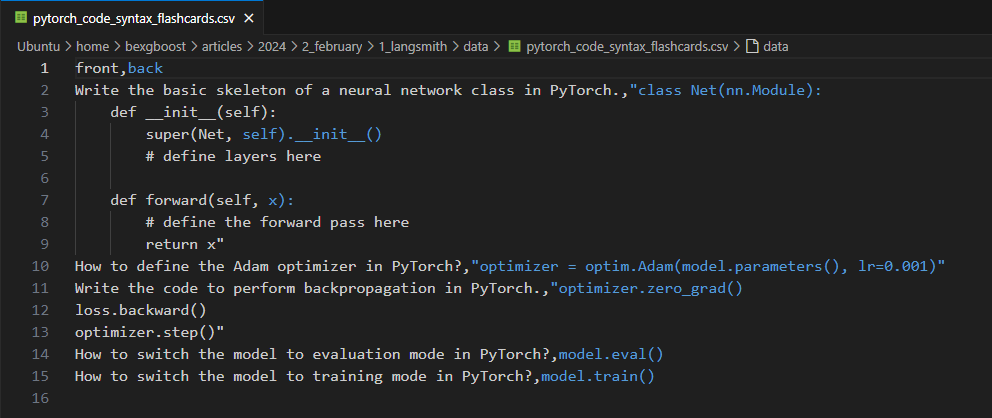

To create a dataset from this, we can use the `upload_csv` function:

In [40]:
dataset_name = "PyTorch code syntax"

csv_path = "data/pytorch_code_syntax_flashcards.csv"
input_keys = ["front"]
output_keys = ["back"]

csv_dataset = client.upload_csv(
    csv_file=csv_path,
    input_keys=input_keys,
    output_keys=output_keys,
    name=dataset_name,
    data_type="kv",
)

The function has three required parameters: csv path and the names of input/output columns. Once the upload finishes, the dataset will appear in the UI:

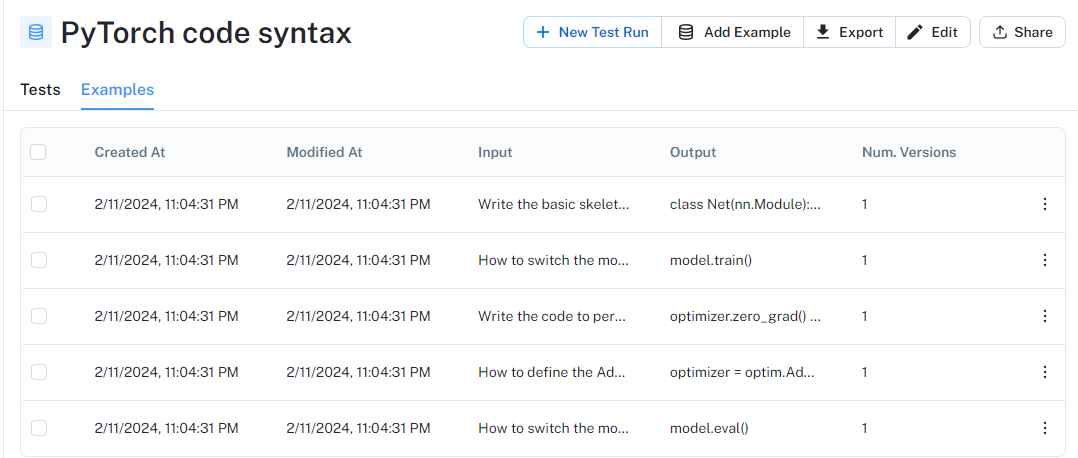

Let's run our custom criterion from the previous section on this dataset as well:

In [41]:
eval_config = RunEvalConfig(
    evaluators=[
        RunEvalConfig.Criteria(
            {"has_code": "Does the card contain a code syntax question?"}
        ),
        RunEvalConfig.Criteria(
            {
                "is_vague": "Is the front of the flashcard vague, meaning it hasn't enough context to answer?"
            }
        ),
    ]
)

In [ ]:
# Run the evaluation
results = run_on_dataset(
    client,
    dataset_name,
    llm,
    evaluation=eval_config,
    project_name="custom_criteria_test_csv",
)

If you go to the dataset page and check out the run, we can see the average scores for each custom criteria:

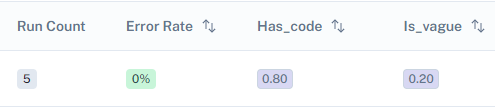

## Evaluating labeled datasets

Built-in and custom evaluators written in natural language are mostly for unlabeled datasets. For labeled datasets like the CSV dataset we uploaded, LangSmith offers more comprehensive evaluators for measuring the correctness of the response to a prompt:
- `context_qa` (contextual Q&A): Uses the sample output as context while evaluating correctness
- `qa` (Q&A): Instructs LLM to directly grade a response as "correct" or "incorrect" using the reference output
- `cot_qa` (Chain-of-thought Q&A): Similar to `context_qa` but this evaluator forces the LLM to use chain-of-thought reasoning before reaching a verdict.

Let's try the last one on our examples:

In [44]:
eval_config = RunEvalConfig(evaluators=[RunEvalConfig.CoTQA()])

results = run_on_dataset(
    client,
    dataset_name,
    llm,
    evaluation=eval_config,
    project_name="cotqa_test",
)

View the evaluation results for project 'cotqa_test' at:
https://smith.langchain.com/o/c50fc75b-a85e-5392-9845-1fd128ea9489/datasets/67ee083c-2051-40ef-852c-5b576faaa7d1/compare?selectedSessions=efea410f-11bc-4277-bd6a-c5a3b0020a22

View all tests for Dataset PyTorch code syntax at:
https://smith.langchain.com/o/c50fc75b-a85e-5392-9845-1fd128ea9489/datasets/67ee083c-2051-40ef-852c-5b576faaa7d1
[------------------------------------------------->] 5/5

`CoTQA` criterion returns a score called `Contextual accuracy`, as depicted in the GIF below (also in the UI):

![](images/cotqa_test.gif)

## Creating a dataset from existing runs and evaluating it

Another use-case with LangSmith is creating datasets from existing LLM results. Here is how:

In [45]:
new_dataset_name = "runs_dataset"

# List the runs for current project
runs = client.list_runs(
    project_name="evaluators",
)

In [46]:
# Create a new dataset
dataset = client.create_dataset(
    new_dataset_name, description="A dataset from existing runs"
)

In [47]:
# Add each run as example to the dataset
for run in runs:
    client.create_example(
        inputs=run.inputs,
        outputs=run.outputs,
        dataset_id=dataset.id,
    )

![](images/runs_dataset.gif)

## Conclusion